# Distribuição das amostras

- 4000 Imagens

- Treino: 3200 (80%)
-- 1600 Real
-- 1600 Fake

- Teste: 400 (10%)
-- 200 Real
-- 200 Fake

- Validacao: 400 (10%)
-- 200 Real
-- 200 Fake


- Generalizacao: 400 (10%) (Similar ao teste)
-- 200 Real
-- 200 Fake

# Estrutura de arquivos

```
./dataset/
├── train/
│   ├── real/
│   └── fake/
├── test/
│   ├── real/
│   └── fake/
├── validation/
│   ├── real/
│   └── fake/
└── general/
    ├── real/
    └── fake/
```

In [ ]:
try:
    import tensorflow
    print("TensorFlow is already installed.")
except ImportError:
    print("TensorFlow is not installed. Installing now...")
    !pip install tensorflow

TensorFlow is already installed.


In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Input, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import random
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)
    print(f"Sementes configuradas com o valor: {seed}")

set_seed(42)

drive.mount('/content/drive')

base_url = '/content/drive/MyDrive/dataset'
train_dir = base_url + '/train'
validation_dir = base_url + '/validation'
test_dir = base_url + '/test'
general_dir = base_url + '/general'

Sementes configuradas com o valor: 42
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Result:
  def __init__(self, acc, val_acc, loss, val_loss):
    self.acc = acc
    self.val_acc = val_acc
    self.loss = loss
    self.val_loss = val_loss


def sharpen_image(image):
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened_image = cv2.filter2D(image, -1, kernel)
    sharpened_image = np.clip(sharpened_image, 0, 255)
    return sharpened_image

def create_model():
  img_shape = (32, 32, 3)

  base_model = EfficientNetV2B0(
      input_shape=img_shape,
      include_top=False,
      weights='imagenet'
  )

  base_model.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(64, activation='relu')(x)
  output_layer = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

def train_model(model, epochs, train_generator, validation_generator, test_generator, general_generator):

  history = model.fit(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  return Result(acc, val_acc, loss, val_loss)

def plot_data(epochs, acc, val_acc, loss, val_loss):
  epochs_range = range(epochs)
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')

def evaluate_model(model, generator):
  loss, accuracy = model.evaluate(generator)

  print(f"Loss: {loss}")
  print(f"Accuracy: {accuracy}")

  y_pred_prob = model.predict(generator)
  y_pred = np.where(y_pred_prob > 0.5, 1, 0).flatten()
  y_true = generator.classes

  print("\nClassification Report:")
  print(classification_report(y_true, y_pred, target_names=list(generator.class_indices.keys())))
  print("\nConfusion Matrix:")
  print(confusion_matrix(y_true, y_pred))

In [1]:
# Dados de treinamento originais
train_datagen_base = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
)

# Dados de treinamento com pre processamento adicional
train_datagen_enhanced = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
    # Adicionais ---
    shear_range=10,
    brightness_range=[0.7, 1.3],
    preprocessing_function=sharpen_image,
)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
general_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
trgt_size = (32, 32)

# Gerador de treino padrao
base_train_generator = train_datagen_base.flow_from_directory(
    train_dir,
    target_size=trgt_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

# Gerador de treino aprimorado
enhanced_train_generator = train_datagen_enhanced.flow_from_directory(
    train_dir,
    target_size=trgt_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)
print("Classes encontradas no treino:", base_train_generator.class_indices)

# Gerador de teste
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=trgt_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
print("Classes encontradas no teste:", test_generator.class_indices)

# Gerador de validacao
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=trgt_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
print("Classes encontradas na validação:", validation_generator.class_indices)

# Gerador para generalizacao
general_generator = general_datagen.flow_from_directory(
    general_dir,
    target_size=trgt_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
print("Classes encontradas no teste (generalizacao):", general_generator.class_indices)

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
class bcolors: # cores para ficar mais facil de ler a saida
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    ENDC = '\033[0m'

epochs = 20
model_normal = create_model()
model_enhanced = create_model()

Sementes configuradas com o valor: 42


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1042s 10s/step - accuracy: 0.5314 - loss: 0.7754 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - accuracy: 0.5729 - loss: 0.7221 - val_accuracy: 0.5500 - val_loss: 0.6848
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - accuracy: 0.5973 - loss: 0.6784 - val_accuracy: 0.6775 - val_loss: 0.6674
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.6069 - loss: 0.6715 - val_accuracy: 0.6800 - val_loss: 0.6471
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - accuracy: 0.6114 - loss: 0.6730 - val_accuracy: 0.6875 - val_loss: 0.6216
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.6298 - loss: 0.6468 - val_accuracy: 0.6900 - val_loss: 0.6026
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.6172 - loss: 0.6415 - val_accuracy: 0.6925 - val_loss: 0.5779
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.6412 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 145s 12s/step - accuracy: 0.8587 - loss: 0.4398
Loss: 0.4954521954059601
Accuracy: 0.7799999713897705
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step

Classification Report:
              precision    recall  f1-score   support

        fake       0.73      0.89      0.80       200
        real       0.85      0.68      0.75       200

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.79      0.78      0.78       400


Confusion Matrix:
[[177  23]
 [ 65 135]]

Pesos do modelo normal salvos em: /content/drive/MyDrive/model_normal_weights.weights.h5



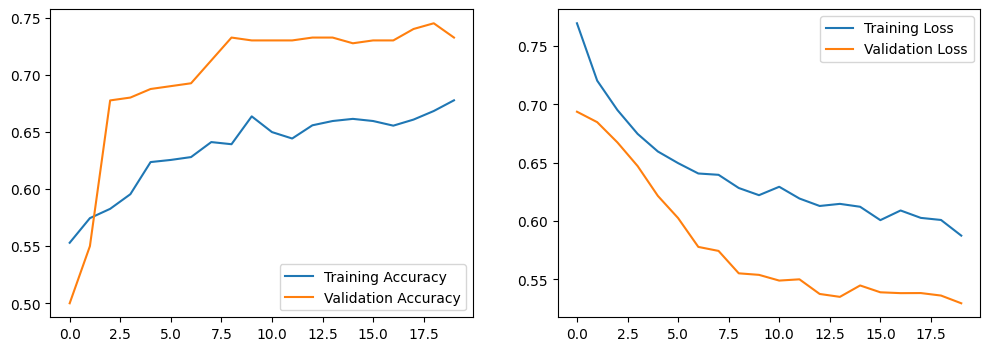

In [ ]:
# Treinar e salvar o modelo base

set_seed(42)
results_normal = train_model(model_normal, epochs, base_train_generator, validation_generator, test_generator, general_generator)

print(f"\n {bcolors.HEADER}==== MOSTRANDO DADOS PARA TREINO NORMAL ===={bcolors.ENDC} \n")
plot_data(epochs, results_normal.acc, results_normal.val_acc, results_normal.loss, results_normal.val_loss)
print(f"\n\n{bcolors.OKBLUE}Resultados para teste{bcolors.ENDC}\n\n")
evaluate_model(model_normal, test_generator)
print(f"\n\n{bcolors.OKCYAN}Resultados para generalizacao{bcolors.ENDC}\n\n")
evaluate_model(model_normal, general_generator)

model_normal_weights_path = '/content/drive/MyDrive/model_normal_weights.weights.h5'
model_normal.save_weights(model_normal_weights_path)
print(f"\n{bcolors.OKBLUE}Pesos do modelo normal salvos em: {model_normal_weights_path}{bcolors.ENDC}\n")

Sementes configuradas com o valor: 42


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 573ms/step - accuracy: 0.5257 - loss: 0.8358 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 52s 392ms/step - accuracy: 0.5492 - loss: 0.7826 - val_accuracy: 0.6675 - val_loss: 0.6828
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - accuracy: 0.5766 - loss: 0.7271 - val_accuracy: 0.6650 - val_loss: 0.6808
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.5887 - loss: 0.7001 - val_accuracy: 0.6775 - val_loss: 0.6738
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 393ms/step - accuracy: 0.6010 - loss: 0.6792 - val_accuracy: 0.6875 - val_loss: 0.6509
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 396ms/step - accuracy: 0.5793 - loss: 0.6867 - val_accuracy: 0.6550 - val_loss: 0.6334
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - accuracy: 0.5949 - loss: 0.6769 - val_accuracy: 0.6375 - val_loss: 0.6323
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.5771 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.6208 - loss: 0.6436
Loss: 0.5858548879623413
Accuracy: 0.6825000047683716
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step

Classification Report:
              precision    recall  f1-score   support

        fake       0.74      0.56      0.64       200
        real       0.65      0.81      0.72       200

    accuracy                           0.68       400
   macro avg       0.69      0.68      0.68       400
weighted avg       0.69      0.68      0.68       400


Confusion Matrix:
[[112  88]
 [ 39 161]]

Pesos do modelo aumentado salvos em: /content/drive/MyDrive/model_enhanced_weights.weights.h5



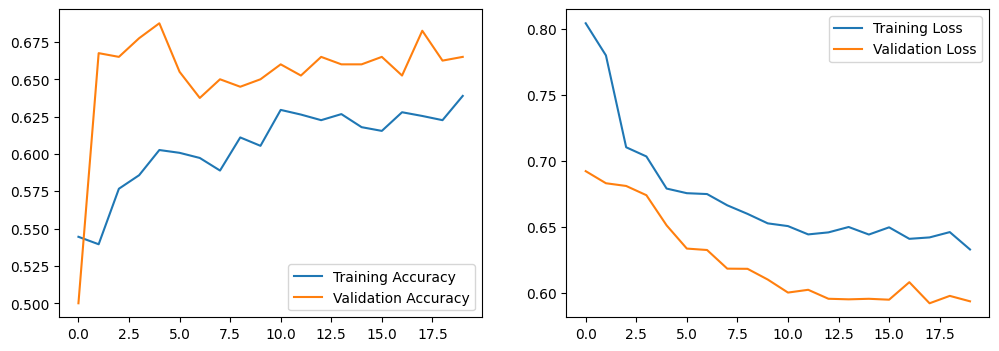

In [ ]:
# Treinar e salvar o modelo aprimorado

set_seed(42)
results_enhanced = train_model(model_enhanced, epochs, enhanced_train_generator, validation_generator, test_generator, general_generator)

print(f"\n {bcolors.HEADER}==== MOSTRANDO DADOS PARA TREINO AUMENTADO ===={bcolors.ENDC} \n")
plot_data(epochs, results_enhanced.acc, results_enhanced.val_acc, results_enhanced.loss, results_enhanced.val_loss)
print(f"\n\n{bcolors.OKBLUE}Resultados para teste{bcolors.ENDC}\n\n")
evaluate_model(model_enhanced, test_generator)
print(f"\n\n{bcolors.OKCYAN}Resultados para generalizacao{bcolors.ENDC}\n\n")
evaluate_model(model_enhanced, general_generator)

model_enhanced_weights_path = '/content/drive/MyDrive/model_enhanced_weights.weights.h5'
model_enhanced.save_weights(model_enhanced_weights_path)
print(f"\n{bcolors.OKBLUE}Pesos do modelo aumentado salvos em: {model_enhanced_weights_path}{bcolors.ENDC}\n")